# Simple Self Contained Model of the Funcspec Project

## Imports

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision.datasets import EMNIST
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
from torchsummary import summary


## Data

### Datasets

In [2]:
from community.data.datasets import get_datasets
from community.common.utils import plot_grid


In [9]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
n_classes = 2
nb_steps = 50
input_size = 28


In [10]:
multi_loaders, double_loaders_dig, double_loaders_letters, single_loaders, letters = get_datasets('../../data', batch_size, use_cuda, fix_asym=False, n_classes=n_classes, split_classes=True)
loaders = double_loaders_letters


### Task

In [11]:
def parity_task(target) : 

    parity = 1 - target.sum(-1)%2
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    return parity_target

def new_parity_task(target) : 
    parity = 1 - target.sum(-1)%2
    equal = (target[:, 0].eq(target[:, 1]))
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    parity_target = torch.where(equal, torch.full_like(parity_target, n_classes), parity_target)

    return parity_target

def temporal_data(data, n_steps=2, device=torch.device('cuda'), flatten=True) :

    data = data.transpose(0, 1)
    if flatten : data = data.flatten(start_dim=2)
    return torch.stack([data for _ in range(n_steps)]).to(device)

def get_data(temporal=False, task=False, flatten=True) : 
    data, target = next(iter(loaders[0]))
    if temporal : data = temporal_data(data, device=device, flatten=flatten)
    if task : target = parity_task(target)

    return data.to(device), target.to(device)


### Data plotting

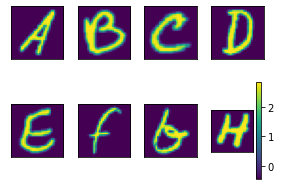

In [5]:
class_split = ([d.truncate_values for d in loaders[0].dataset.datasets])
idxs = [[(d.targets == c).float().argmax() for c in range(n_classes)] for d in loaders[0].dataset.datasets]
datas = [[d[i][0] for i in idx] for d, idx in zip(loaders[0].dataset.datasets, idxs)]
plot_grid(datas, figsize=(n_classes, 3))


In [6]:
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])
all_targets = get_all_targets()
uniques, unique_counts = all_targets.unique(dim=0, return_counts=True)
task_t = parity_task(all_targets)
task_t.unique(dim=0, return_counts=True), (all_targets[:, 0] == task_t).unique(dim=0, return_counts=True), (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)

((tensor([0, 1, 2, 3]), tensor([2172, 2180, 2160, 2192])),
 (tensor([False,  True]), tensor([4341, 4363])),
 (tensor([False,  True]), tensor([4363, 4341])))

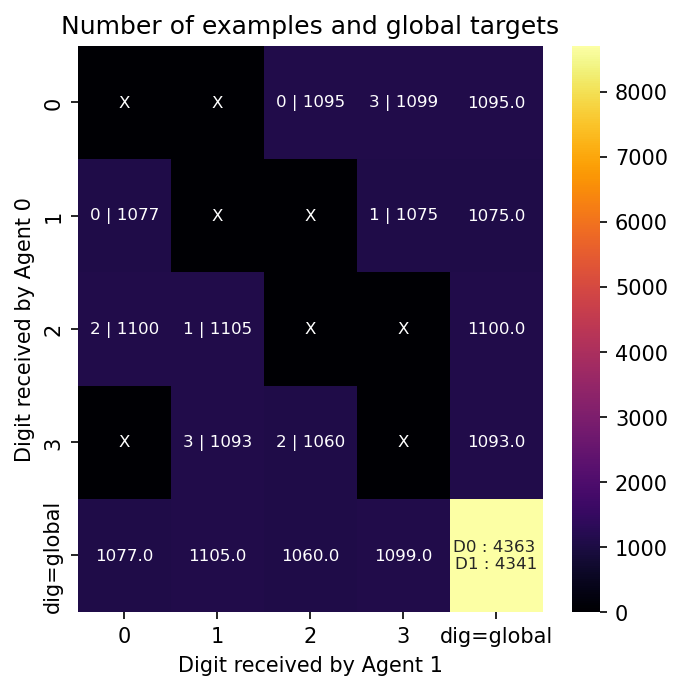

In [7]:
digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
counts = np.zeros((n_classes+1, n_classes+1))
targets = np.zeros((n_classes+1, n_classes+1), dtype=object)

for d1 in range(n_classes) : 
    counts[d1, -1] = ((all_targets[:, 0] == task_t)[all_targets[:, 0] == d1]).sum() #unique_counts[(uniques == d1)[:, 0]].sum()
    targets[d1, -1] = str( counts[d1, -1])
    for d2 in range(n_classes) : 
        if digits_in(d1, d2) : 
            counts[d1, d2] = unique_counts[digits_idx(d1, d2)]
            targets[d1, d2] = f'{parity_task(uniques)[digits_idx(d1, d2)].cpu().data.item()} | {unique_counts[digits_idx(d1, d2)]}'
        else : 
            counts[d1, d2] = -0.1
            targets[d1, d2] = 'X'
        counts[-1, d2] = ((all_targets[:, 1] == task_t)[all_targets[:, 1] == d2]).sum() #unique_counts[(uniques == d2)[:, 1]].sum()
        targets[-1, d2] = str( counts[-1, d2])

counts[-1, -1] = unique_counts.sum().cpu().data.item()
targets[-1, -1] = str(f'D0 : {(all_targets[:, 0] == task_t).unique(dim=0, return_counts=True)[1][1]} \n' + 
                 f'D1 : {(all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)[1][1]}')
            
plt.figure(figsize=(5, 5), dpi=150)
ax = sns.heatmap(counts, cmap="inferno", annot=targets, annot_kws={'fontsize': 8}, fmt='s')
ax.set_title('Number of examples and global targets')

ax.set_xlabel('Digit received by Agent 1')
ax.set_ylabel('Digit received by Agent 0')
ax.set_xticklabels([str(i) for i in range(n_classes)] + ['dig=global'])
ax.set_yticklabels([str(i) for i in range(n_classes)] + ['dig=global'])

plt.show()

## New Synth Dataset for counting symbols

In [12]:
symbols = X, C = (np.array([[0, 0, 0, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 1, 0, 1]]),
                        np.array([[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 1, 1], [0, 0, 1, 0]]) )

def get_random_symbol_data(data_size, nb_steps=10,  n_symbols=4, symbol_size=4, input_size=28, static=True) : 
        
    assert np.remainder(input_size, symbol_size) == 0
    n_grid = input_size//symbol_size
    assert n_symbols <= n_grid

    if static : 
            
        squares = list(range((n_grid)**2))
        positions = np.stack([np.random.choice(squares, n_symbols, replace=False) for _ in range(data_size)])
        centers = np.stack(
            [np.array(np.unravel_index(positions, (n_grid, n_grid))).transpose(1, 2, 0) * symbol_size
            for _ in range(nb_steps)])
        jitter = np.repeat(np.random.random_integers(-1, 0, (data_size, 2))[:, None, :], n_symbols, axis=1)

    else : 
        centers = np.stack(
            [[np.stack(
                get_random_trajectory(nb_steps, input_size, symbol_size)).T for _ in range(n_symbols)]
                for _ in range(data_size)]
                            
             ).transpose(2, 0, 1, -1)
        #return 0, 0, 0, centers
        ""

    labels = np.random.random_integers(0, 1, (data_size, n_symbols))

    grids = place_symbols_from_centers(centers, labels, data_size, input_size, symbol_size)

    return torch.from_numpy(grids).transpose(0, 1), torch.from_numpy(labels).sum(-1), torch.from_numpy(centers)#, torch.from_numpy(jitter)


def place_symbols_from_centers(centers, labels, data_size, input_size, symbol_size) : 

    grids = []
    def assign_square(grid, center_pos, l, d) : 
        grid[d, center_pos[0] : center_pos[0] + symbol_size, center_pos[1] : center_pos[1] + symbol_size] += symbols[l]

    for center in centers : 
        grid = np.zeros((data_size, input_size, input_size))

        for d in range(data_size) : 
            for l, c in zip(labels[d], center[d]) : 
                assign_square(grid, (c[0], c[1]), l, d)

        grids.append(grid)
        
    return np.stack(grids)

def get_random_trajectory(seq_length, image_size=28, symbol_size=4, step_length=0.2):
    """
    Generate a trajectory
    https://tcapelle.github.io/pytorch/fastai/cv/2021/05/01/moving_mnist.html
    """
    canvas_size = image_size - symbol_size
    x, y = np.random.random(2)
    v_min = 1 / (step_length * canvas_size)
    v_x, v_y = np.random.random(2) * (1 - v_min) + v_min

    assert v_x * step_length * canvas_size >= 1
    assert v_y * step_length * canvas_size >= 1

    out_x, out_y = [], []
    
    for i in range(seq_length):
        # Take a step along velocity.
        y += v_y * step_length
        x += v_x * step_length

        # Bounce off edges.
        if x <= 0:
            x = 0
            v_x = -v_x
        if x >= 1.0:
            x = 1.0
            v_x = -v_x
        if y <= 0:
            y = 0
            v_y = -v_y
        if y >= 1.0:
            y = 1.0
            v_y = -v_y
        out_x.append(x * canvas_size)
        out_y.append(y * canvas_size)

    return torch.tensor(out_x).int(),  torch.tensor(out_y).int()

In [13]:
## Data handling

def batch_generator(X, y, batch_size, shuffle = True, use_conv=False): 
    
    labels_ = np.array(y, dtype = np.int)
    number_of_batches = len(X) // batch_size
    sample_index = np.arange(len(X))
    
    if shuffle: 
        np.random.shuffle(sample_index)
        
    total_batch_count = 0 
    counter = 0
    while counter < number_of_batches: 
        batch_index = sample_index[(batch_size * counter):(batch_size * (counter + 1))]
        X_batch = X[batch_index, :, :]
        y_batch = torch.tensor(labels_[batch_index], device = device)
        
        X_batch, y_batch = X_batch.to(device = device).float().permute(2, 1, 0, 3, 4) , y_batch.to(device = device).float()

        if not use_conv : 
            X_batch = X_batch.flatten(start_dim=-2)
        else : 
            X_batch = X_batch.unsqueeze(3)
        
        yield X_batch, y_batch
        
        counter += 1   

def get_mini_batch(x_data, y_data, batch_size, shuffle = False, use_conv=False): 
    for ret in batch_generator(x_data, y_data, batch_size, shuffle = shuffle, use_conv=use_conv):
        return ret

def get_double_data(data_size, nb_steps=10, n_symbols=4, symbol_size=4, input_size=28, static=True) : 
    print(locals())
    datas = get_random_symbol_data(*list(locals().values())), get_random_symbol_data(*list(locals().values()))

    return [torch.stack((d1, d2), axis=1) for d1, d2 in zip(*datas)]

In [32]:
def symbol_count(label) : 
    new_label = torch.where(label.argmax(-1).bool(), label[:, 1], label[:, 0])
    new_label[label[:, 0] == label[:, 1]] = 0
    return new_label.type(torch.LongTensor).to(label.device)

In [156]:
try : 
    data_dict = torch.load(f'data/generated_data_{n_classes}_classes')
    data_train, label_train = list(data_dict['Train'].values())
    data_test, label_test = list(data_dict['Test'].values())

except FileNotFoundError : 
    data_sizes = (60000, 10000)
    data_train, label_train, *_ = get_double_data(data_sizes[0], nb_steps=nb_steps, n_symbols=n_classes-1, static=False)
    data_test, label_test, *_ = get_double_data(data_sizes[1], nb_steps=nb_steps, n_symbols=n_classes-1, static=False)
    data_train.shape

    torch.save({t : {'data' : data, 'label' : label} for t, data, label in zip(['Train', 'Test'], [data_train, data_test], [label_train, label_test])}, f'data/generated_data_{n_classes}_classes')

{'data_size': 60000, 'nb_steps': 50, 'n_symbols': 1, 'symbol_size': 4, 'input_size': 28, 'static': False}


/tmp/ipykernel_3028/3616552810.py:29: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  labels = np.random.random_integers(0, 1, (data_size, n_symbols))


{'data_size': 10000, 'nb_steps': 50, 'n_symbols': 1, 'symbol_size': 4, 'input_size': 28, 'static': False}


In [134]:
#torch.save({t : {'data' : data, 'label' : label} for t, data, label in zip(['Train', 'Test'], [data_train, data_test], [label_train, label_test])}, 'generated_data')

In [17]:
symbol_loaders = lambda use_conv : (batch_generator(data_train, label_train, batch_size, shuffle=True, use_conv=use_conv), batch_generator(data_test, label_test, batch_size, shuffle=False, use_conv=use_conv))

In [18]:
datas, labels = get_mini_batch(data_train, label_train, batch_size, use_conv=False)
datas.shape, labels.unique(return_counts=True)

/tmp/ipykernel_3028/2805407236.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y, dtype = np.int)


(torch.Size([50, 2, 256, 784]),
 (tensor([0., 1.], device='cuda:0'), tensor([269, 243], device='cuda:0')))

In [19]:
from PIL import Image
import shutil, os

def create_gif(img_list, l, w, name) : 
        
    images_list = [Image.fromarray(img.reshape(w, l)).resize((256, 256)) for img in img_list]
    images_list = images_list # + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{name}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=10)
try : 
    shutil.rmtree('gifs/')
    os.mkdir('gifs')
except FileNotFoundError : 
    os.mkdir('gifs')
    'continue'

"""
grid, labels, centers = get_random_symbol_data(10, nb_steps=30, static=False)

plt.figure()
for cent in centers[:, 0].transpose(0, 1) : 
    plt.plot(cent[:, 0], cent[:, 1])

plt.title('Centers\' Positions')
plt.show()
"""
grid = get_mini_batch(data_train, label_train, batch_size)[0].transpose(2, 0)

#grid = data_train[:10, 0]

img_list = lambda data, i : [data[i, :, t].cpu().data.numpy()*255 for t in range(nb_steps)]
for i in range(len(grid[:10])): 
    create_gif(img_list(grid, i), 28, 2*28, f'gifs/symbols_{i}')
    #create_gif(img_list(x_train, i), 14, 14*2, fig_path / '{y_train[i]}_{i}_{global_cohs_train[i]}')

/tmp/ipykernel_3028/2805407236.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y, dtype = np.int)


## Models

In [ ]:
class SmoothStep(torch.autograd.Function):
    '''
    Modified from: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    '''

    @staticmethod
    def forward(aux, x, thr=0):
        aux.save_for_backward(x)
        return (x >=thr).type(x.dtype)

    def backward(aux, grad_output):
        # grad_input = grad_output.clone()
        input, = aux.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= -.5] = 0
        grad_input[input > .5] = 0
        return grad_input
    
smooth_step = SmoothStep().apply
sigmoid = nn.Sigmoid()

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input, thr=0):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > thr] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
super_spike  = SurrGradSpike.apply

In [57]:
class Agent(nn.Module) : 

    def __init__(self, dims, use_conv=False) : 
        super().__init__()
        if use_conv : 
            self.conv = nn.Sequential(nn.Conv2d(1, 1, 3, 1, 1), nn.Flatten())
        else : 
            self.conv = None

        self.cell = nn.RNN(dims[0], dims[1], 1, bias=False, batch_first=False)
        self.readout = nn.Linear(dims[1], dims[2], bias=False)

    def forward(self, input, state=None, connections=0) : 

        if self.conv : 
            input = self.conv(input)

        if len(input.shape ) < 3 : 
            input = input.unsqueeze(0)

        if state is None : 
            out, h = self.cell(input)
        else : 
            h = state + connections
            out, h = self.cell(input, h)

        out = self.readout(out[0])

        return out, h

class Connection(nn.Linear) : 
    def __init__(self, dims, p, binarize=False) : 

        super().__init__(dims[0], dims[1], bias=False)

        self.sparsity = p
        n_in, n_out = dims
        self.nb_non_zero = int(p*n_in*n_out)
        w_mask = np.zeros((n_in, n_out),dtype=bool)
        ind_in, ind_out = np.unravel_index(np.random.choice(np.arange(n_in*n_out), self.nb_non_zero, replace=False), (n_in, n_out))
        w_mask[ind_in,ind_out] = True
        w_mask = torch.tensor(w_mask)
        self.register_buffer('w_mask', w_mask)
        self.binarize = binarize

        assert w_mask.sum() == self.nb_non_zero, f'Number of nonzero connection is {w_mask.sum()}, expected {self.nb_non_zero}'

    def forward(self, input) : 
        out = F.linear(input, self.weight*self.w_mask)
        assert (out != 0).float().sum(-1).max() <= self.nb_non_zero, f'{(out != 0).float().sum(-1).max()} non zero connections !'
        if self.binarize  : 
            out = super_spike(out)

        return out

class Ensemble(nn.Module) : 
    def __init__(self, dims, p, use_conv=False, binary_con=False) : 

        super().__init__()
        self.n_in, self.n_hid, self.n_out = dims
        self.agents = nn.ModuleList([Agent(dims, use_conv) for _ in range(2)])[::-1]
        self.connections = nn.ModuleList([Connection([dims[1]]*2, p, binary_con) for _ in range(2)])

    def forward(self, input): 

        states, outputs, conns = [None for _ in range(2)], [[] for _ in range(2)], [None for _ in range(2)]
        
        for t, t_input in enumerate(input) :
            for ag, agent in enumerate(self.agents) : 
                
                ag_input = t_input[ag]
                
                if t>0 : 
                    input_connect = self.connections[1-ag](states[1-ag])
                else : 
                    input_connect = 0
                
                out, h = agent(ag_input, states[ag], input_connect)


                states[ag] = h
                outputs[ag].append(out)
                conns[ag] = input_connect

        outputs = torch.stack([torch.stack(o) for o in outputs], 1)
        states = torch.stack(states, 1)[0]
        conns = torch.stack(conns, 1)[0]

        #print((outputs[-1][1] == outputs[-1][1]).all())

        return outputs, states, conns
     

## Decisions


In [144]:
def get_decision(outputs, decision_params, target=None) : 
    temporal_decision, agent_decision = decision_params

    if temporal_decision == 'last' : 
        outputs = outputs[-1]

    else : 
        raise NotImplementedError

    try : 
        deciding_ags = int(agent_decision)
        outputs = outputs[deciding_ags]
        deciding_ags = torch.ones(outputs.shape[0])*deciding_ags
        return outputs, deciding_ags

    except ValueError : 

        if agent_decision == 'loss' :
            assert target is not None, 'Provide target for min loss decision'
            loss, min_idxs = torch.stack([F.cross_entropy(out, target, reduction='none') for out in outputs]).min(0)
            min_idxs = min_idxs.unsqueeze(-1).expand_as(outputs[0])
            outputs = torch.where(~min_idxs.bool(), outputs[0], outputs[1])
            deciding_ags = min_idxs[..., 0]
            return outputs, deciding_ags

        else : 
            raise NotImplementedError

def check_grad(model, task_id = '0') : 
    for n, p in model.named_parameters() : 
        if 'k_params' in n or 'all_scores' in n : 
            if task_id in n : 
                return check_ind_grad(n, p)
        else : 
            check_ind_grad(n, p)

def check_ind_grad(n, p) : 
    if p.grad is not None : 
        if (p.grad == 0).all() : 
            ''
            print(f'{n}, Zero Grad')
        #else : print(f'{n} : {p.grad}')
    elif p.requires_grad : 
        ''
        print(f'{n}, None Grad')

## Init

In [145]:
use_symbols = True
task = parity_task if not use_symbols else symbol_count

In [154]:
dims = [784, 50, n_classes]
sparsity = 1 * 1/dims[1]**2

use_conv = False
binary_connections = True

community = Ensemble(dims, sparsity, use_conv, binary_connections).to(device)
optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)
datas, labels = get_mini_batch(data_train, label_train, batch_size, use_conv=use_conv)

summary(community.agents[0], (1, 28, 28) if use_conv else (1, 28**2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 50], [-1, 1, 50]]               0
            Linear-2                    [-1, 2]             100
Total params: 100
Trainable params: 100
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


/tmp/ipykernel_3028/2805407236.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y, dtype = np.int)


In [147]:
data, target = get_data() if not use_symbols else get_mini_batch(data_train, label_train, batch_size, use_conv=use_conv, shuffle=True)
data = temporal_data(data) if not use_symbols else data
out, states, conns = community(data)
symbol_count(target).unique(return_counts=True), (symbol_count(target) == target[:, 0]).unique(return_counts=True)

/tmp/ipykernel_3028/2805407236.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y, dtype = np.int)


((tensor([0, 1], device='cuda:0'), tensor([125, 131], device='cuda:0')),
 (tensor([False,  True], device='cuda:0'),
  tensor([120, 136], device='cuda:0')))

In [133]:
#make_dot(out[-1][1], dict(community.named_parameters())).render('graph')

## Training

In [155]:
n_epochs = 10

decision_params = ('last', '0') # Change to '0', '1' or 'loss'
pbar = tqdm_n(range(n_epochs))
descs = np.full((2), '', dtype=object)
check_gradients = False

#train_loader, test_loader = loaders if not symbols else symbol_loaders()
#subset = len(train_loader) if not symbols else 100000

for epoch in pbar : 
    train_loader, test_loader = loaders if not use_symbols else symbol_loaders(use_conv)

    # Training

    for batch_idx, (data, target) in enumerate(train_loader) : 
        
        data = temporal_data(data, device=device) if not use_symbols else data
        target = task(target).to(device)

        optimizer.zero_grad()

        outputs, states, conns = community(data)
        #print((outputs[-1][0] == outputs[-1][1]).all())
        output, deciding_ags = get_decision(outputs, decision_params, target)

        loss = F.cross_entropy(output, target)
        loss.backward()

        if check_gradients : 
            zero_grads = np.array([((p.grad == 0).all()).cpu().data.item() for p in community.parameters() if p.grad is not None])
            none_grads = np.array([p.grad is None for p in community.parameters()])
            zero_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[~none_grads][zero_grads]
            none_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[none_grads]

            print(f'Zero params : {zero_params}')
            #print(f'None Params : {none_params}')
            
        optimizer.step()

        pred = output.argmax(dim=-1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().cpu().data.item()
        acc = (correct / target.numel())

        descs[0] = str('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.3f}, Accuracy: {}%'.format(
                        epoch, batch_idx  * batch_size, len(train_loader.dataset) if not use_symbols else data_sizes[0],
                        100. * batch_idx / len(train_loader) if not use_symbols else 0, loss.item(),
                        (np.round(100*a) for a in acc) if type(acc) is list else np.round(100*acc))
                        )

        pbar.set_description((descs.sum()))

        if acc > 0.95 : 
            break


    for batch_idx, (data, target) in enumerate(test_loader) : 
        
        data = temporal_data(data, device=device) if not use_symbols else data
        target = task(target).to(device)

        outputs, states, conns = community(data)
        #print((outputs[-1][0] == outputs[-1][1]).all())
        output, deciding_ags = get_decision(outputs, decision_params, target)

        loss = F.cross_entropy(output, target)

        pred = output.argmax(dim=-1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().cpu().data.item()
        acc = (correct / target.numel())

        descs[1] = str('| Test : Loss: {:.3f}, Accuracy: {}%'.format(
                        loss.item(),
                        (np.round(100*a) for a in acc) if type(acc) is list else np.round(100*acc))
                        )

        pbar.set_description((descs.sum()))


        if acc > 0.95 : 
            break
            #continue

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_3028/2805407236.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y, dtype = np.int)


KeyboardInterrupt: 

## Analysis


### Connections

/tmp/ipykernel_3028/2805407236.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y, dtype = np.int)


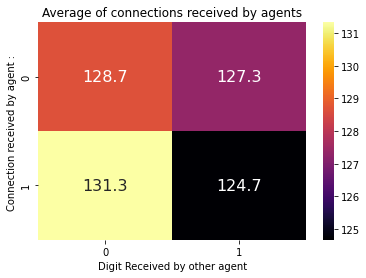

In [151]:
community.to(device)
sums = []
nonzero_idxs = [c.w_mask.nonzero()[:, 0] for c in community.connections]
loaders = train_loader, test_loader = loaders if not use_symbols else symbol_loaders(use_conv)

for data, target in loaders[1] : 
    
    data, target = temporal_data(data, device=device) if not use_symbols else data, target.to(device)    
    out, states, conns = community(data.to(device))
    
    #conns[-1][0].count_nonzero(dim=0)
    #torch.stack([conns[-1][i].count_nonzero(dim=0).max() for i in range(2)])
    #sums.append(torch.tensor([[conns[-1][i][target[:, i] == t].sum() for t in range(4)] for i in range(2)]))
    sums.append(torch.stack([torch.stack([conns[i][target[:, 1-i] == t][:, nonzero_idxs[1-i]].sum(0) for t in range(n_classes)]) for i in range(2)]))

sums = torch.stack(sums).cpu().data.numpy().mean(0)[..., 0]
ax = sns.heatmap(sums, cmap="inferno", annot=sums.round(1).astype(str), annot_kws={'fontsize': 16}, fmt='s')
ax.set_xlabel('Digit Received by other agent')
ax.set_ylabel('Connection received by agent : ')
ax.set_title('Average of connections received by agents')
plt.show()

 ### Decisions

/tmp/ipykernel_3028/2805407236.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y, dtype = np.int)
/tmp/ipykernel_3028/1136200632.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = target.eq(torch.tensor(t)).all(axis=1)


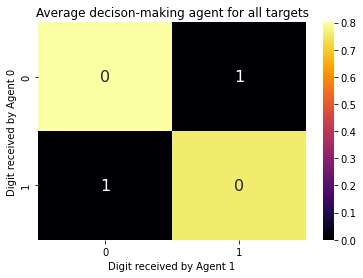

In [152]:
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])
loaders = train_loader, test_loader = loaders if not use_symbols else symbol_loaders(use_conv)


if 'all_targets' not in globals() : 
    all_targets = get_all_targets()

uniques = all_targets.unique(dim=0).cpu()
decision_means = torch.zeros(len(uniques))

loaders = train_loader, test_loader = loaders if not use_symbols else symbol_loaders(use_conv)
community.to('cpu')
for data, target in loaders[1] : 
    
    data, target = temporal_data(data, device='cpu') if not use_symbols else data.cpu(), target.cpu()
    t_target = task(target).cpu()
    output, *_ = community(data)
    output, decision_ags = get_decision(output, decision_params, target=t_target)

    for i, t in enumerate(uniques) : 
        mask = target.eq(torch.tensor(t)).all(axis=1)
        decision_means[i] += decision_ags[mask].float().cpu().sum()/mask.numel()

digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
decisions = np.zeros((n_classes, n_classes))
targets = np.zeros((n_classes, n_classes), dtype=object)

for d1 in range(n_classes) : 
    for d2 in range(n_classes) : 
        if digits_in(d1, d2) : 
            decisions[d1, d2] = decision_means[digits_idx(d1, d2)]
            targets[d1, d2] = str(task(uniques)[digits_idx(d1, d2)].cpu().data.item())
        else : 
            decisions[d1, d2] = -0.1
            targets[d1, d2] = 'X'
            
ax = sns.heatmap(decisions, cmap="inferno", annot=targets, annot_kws={'fontsize': 16}, fmt='s')
ax.set_title('Average decison-making agent for all targets')

ax.set_xlabel('Digit received by Agent 1')
ax.set_ylabel('Digit received by Agent 0')

plt.show()

In [153]:
decision_means

tensor([0.8008, 0.0000, 0.0000, 0.7539])

# Whyyyy